In [ ]:
# Importation des Bibliothèques 
import os
import sys
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterstats import zonal_stats
sys.path.append('/home/onyxia/work/Depot_Git/scripts')
from my_function import (
    count_polygons_by_class,
    plot_bar,
    violin_plot,
)

In [ ]:
# definition des paramètres 
my_folder = '/home/onyxia/work/Depot_Git/results/data/sample'
out_folder = '/home/onyxia/work/Depot_Git/results/figure'
in_vector = os.path.join(my_folder, 'Sample_BD_foret_T31TCJ.shp')
diag_baton_poly_classe_path = os.path.join(out_folder,'diag_baton_nb_poly_by_class.png')
diag_baton_pixel_classe_path = os.path.join(out_folder,'diag_baton_nb_pix_by_class.png')
violin_plot_path = os.path.join(out_folder,'violin_plot_nb_pix_by_poly_by_class.png')
violin_plot_filt_path= os.path.join(out_folder,'violin_plot_nb_pix_by_poly_by_class_filtred.png')
raster_path = "/home/onyxia/work/Depot_Git/results/data/img_pretraitees/masque_foret.tif"


In [9]:
# Chargement des données de BD_Forêt
echantillons = gpd.read_file(in_vector)
echantillons.head()

,ID,CODE_TFV,TFV,TFV_G11,ESSENCE,classif_pi,Code_pixel,classif_ob,Objet_code,geometry
0,FORESTIE0000000003108720,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,None,None,Feuillus en îlots,16,"POLYGON ((542016.264 6240744.823, 542019.845 6..."
1,FORESTIE0000000003108753,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,None,None,Feuillus en îlots,16,"POLYGON ((542369.772 6240980.009, 542369.28 62..."
2,FORESTIE0000000003116029,FF1-00-00,Forêt fermée à mélange de feuillus,Forêt fermée feuillus,Feuillus,None,None,Mélange de feuillus,15,"POLYGON ((541667.758 6240990.232, 541662.797 6..."
3,FORESTIE0000000003108760,FF1-00,Forêt fermée de feuillus purs en îlots,Forêt fermée feuillus,Feuillus,None,None,Feuillus en îlots,16,"POLYGON ((545450.8 6241119, 545446 6241115.3, ..."
4,FORESTIE0000000003116048,FF1-00-00,Forêt fermée à mélange de feuillus,Forêt fermée feuillus,Feuillus,None,None,Mélange de feuillus,15,"POLYGON ((545762.816 6241493.748, 545772.766 6..."


In [10]:
# Visualisation sous forme d'un diagramme en bâton du nombre des polygones par classe 
# Définition des un variable stockant le nom de colone classif polygone
nom_poly_col = "classif_ob" 
# Comptage de  nombre des polygones par classe
nb_pol_by_class = count_polygons_by_class(echantillons, nom_poly_col)
print(nb_pol_by_class)

                                        classif_ob  count
0                                       Autres Pin      8
1                   Autres conifères autre que pin      5
2                                  Autres feuillus    128
3                                            Chêne   2172
4                               Conifères en îlots     39
5                                          Douglas     18
6                                Feuillus en îlots   5325
7                                Mélange conifères     19
8   Mélange de conifères prépondérants et feuillus    119
9                              Mélange de feuillus   2641
10  Mélange de feuillus prépondérants et conifères    199
11                                      Peupleraie    172
12                         Pin laricio ou pin noir     97
13                                    Pin maritime     23
14                                        Robinier     56


In [11]:
# Visualisation Grapique de distribution des polygones sur les différentes classes 
plot_bar (
    nb_pol_by_class,
    title = "Nombre de polygones par classe",
    xlabel = "Classe",
    ylabel = "Nombre de polygones",
    output_path = diag_baton_poly_classe_path)

<Figure size 1000x600 with 0 Axes>

In [13]:
# Rastérisation de la couche des échantillons  à l'aide de la fonction zonal_stat de Rasterstats et calcul de l'effectif de pixels pour chaque classe 
stats = zonal_stats(
    echantillons,
    raster_path,
    stats=["count"],      # comtage de nombre de pixels
    categorical=True,     # Regrouper les pixels par catégorie
    geojson_out=False     # Retourner les résultats sous forme d'une liste
)

/opt/conda/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [14]:
type(stats)

list

In [16]:
#  Pour chaque catégoie dans la liste stats générée précedement, on associe la classe correspondante pour obtenir le nombre de pixels par classe
results = []
for i, stat in enumerate(stats):
    classe = echantillons.iloc[i]["classif_pi"]  # Remplacer par le nom du champ de classe
    if stat:
        for category, count in stat.items():
            results.append({"Classe": classe, "Catégorie": category, "Pixels": count})
    else:
        results.append({"Classe": classe, "Catégorie": "N/A", "Pixels": 0})
# Convertir les résultats en DataFrame et regrouper par classe
df = pd.DataFrame(results)
nb_pixel_by_class = df.groupby("Classe")["Pixels"].sum().reset_index()
nb_pixel_by_class


,Classe,Pixels
0,Autres Pin,7820
1,Autres conifères autre que pin,2784
2,Autres feuillus,141616
3,Chêne,4442418
4,Douglas,43568
5,Peupleraie,107730
6,Pin laricio ou pin noir,104576
7,Pin maritime,33362
8,Robinier,43992


In [17]:
# Visualisation Grapique sous forme d'un diagramme en bâton de la distribution des pixels sur les différentes classes 
plot_bar (
    nb_pixel_by_class,
    title = "Nombre de pixels par classe",
    xlabel = "Classe",
    ylabel = "Nombre de pixels",
    output_path = diag_baton_pixel_classe_path)

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Création de "violin plot" pour visualiser la distribution du nombre de pixels par polygone, par classe
violin_plot(
    df=df,
    x_col="Classe",
    y_col="Pixels",
    output_file=violin_plot_path, 
    title="Distribution du nombre de pixels par polygone, par classe",
    xlabel="Classe",
    ylabel="Nombre de pixels par polygone",
    palette="muted"
)

NameError: name 'violin_plot' is not defined

/home/onyxia/work/Projet_Teledec/scripts/my_function.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=x_col, y=y_col, palette=palette)


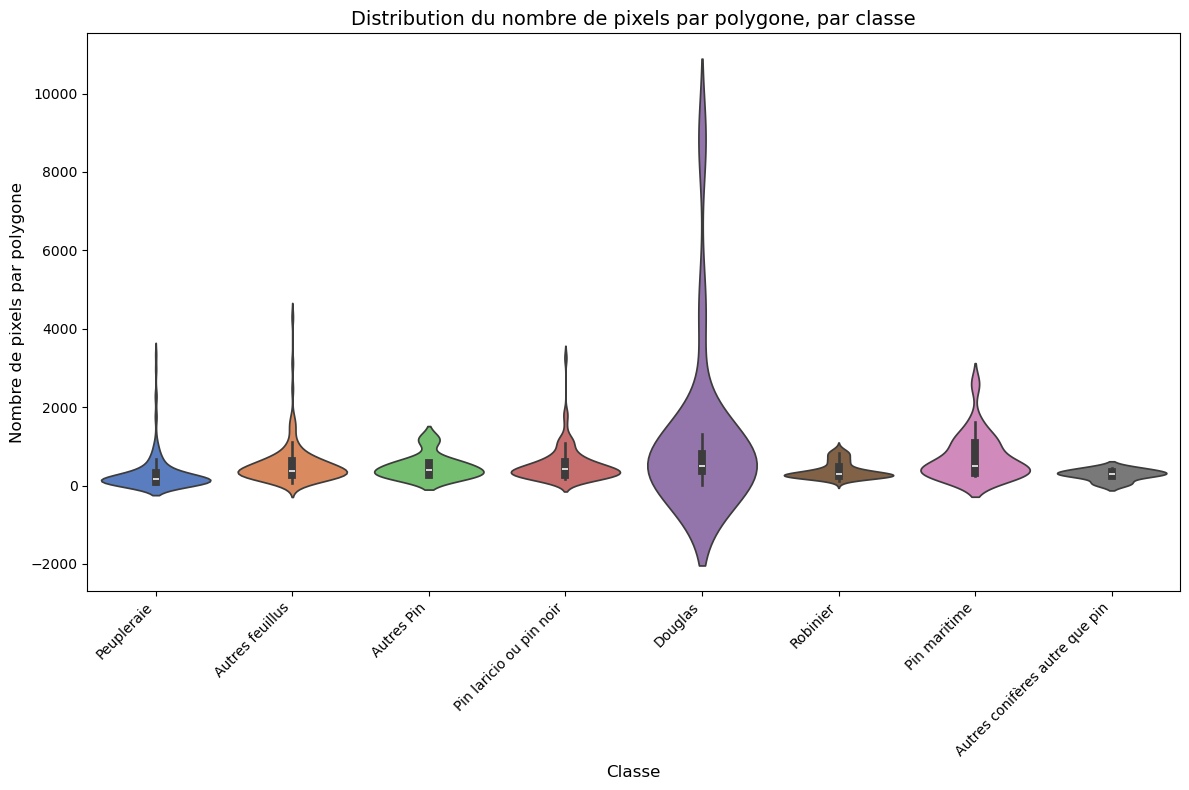

In [ ]:
# Création de "violin plot" pour visualiser la distribution du nombre de pixels par polygone, par classe sans tenir compte de la classe dominante chêne 
df_filtered = df[df["Classe"] != "Chêne"]
violin_plot(
    df = df_filtered,
    x_col = "Classe",
    y_col ="Pixels",
    output_file =violin_plot_filt_path,
    title ="Distribution du nombre de pixels par polygone, par classe",
    xlabel = "Classe",
    ylabel = "Nombre de pixels par polygone",
    palette = "muted"
)